<a href="https://colab.research.google.com/github/Asuna-sama-1/Horror_movies/blob/main/Horror_movie_review_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from collections import Counter

from itertools import chain
from wordcloud import WordCloud
import pandas_profiling

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

def print_info(df,feature):
   print('Description:\n{}'.format(df[feature].describe()))
   print('*'*50)
   print('Object type:\n{}'.format(df[feature].dtype))
   print('*'*50)
   value_cnt = value_cnt_norm_cal(df,feature)
   print('Value count:\n{}'.format(value_cnt))

def create_bar_plot(df,feature):
  fig, ax = plt.subplots(figsize=(5,8))
  sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
  plt.xlabel('{}'.format(feature))
  plt.ylabel('Count')
  plt.title('{} count'.format(feature))
  total = float(len(df[feature])) 
  for i,n in enumerate(df[feature].value_counts(ascending = False)):
    percentage = '{:.1f}%'.format(n/total*100)
    i = i - 0.2
    n = n + 100
    ax.annotate(percentage,xy=(i,n))
  return plt.show()

def top_n_bar_plot(df,feature,n):
  fig, ax = plt.subplots(figsize=(20,4))
  sns.barplot(x=value_cnt_norm_cal(df,feature).index[:n],y=value_cnt_norm_cal(df,feature).values[:n,0])
  ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
  plt.xlabel('{}'.format(feature))
  plt.ylabel('Count')
  plt.title('Top {} {} count'.format(n,feature))
  return plt.show()

def create_hist_plot(df, feature, num_bin):
  if feature in ['review_date']:
    df[feature] = pd.to_datetime(df[feature])
    fig, ax = plt.subplots(figsize=(15,8))
    sns.histplot(df[feature],bins=num_bin,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()
  else:
    fig, ax = plt.subplots(figsize=(15,8))
    sns.histplot(df[feature],bins=num_bin,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

## 1. Load Data 

In [3]:
movies_data= pd.read_csv('rotten_tomatoes_movies.csv')
review_data = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

In [4]:
review_data.shape

(1130017, 8)

In [5]:
# get rid of null values in genres 
movies_data = movies_data[~movies_data['genres'].isnull()]

# get horror related movies
movies_data=movies_data[movies_data['genres'].str.contains('Horror')]

In [6]:
merged_data = pd.merge(review_data,movies_data,on='rotten_tomatoes_link').iloc[:,:8]

## 2. Data Cleaning

In [14]:
data = merged_data.copy()

### 2.1 Duplicates

In [15]:
def check_duplicates(df):
  if df.duplicated().sum() == 0:
    print('No duplicates detected')
  else:
    print('Orginal contains',df.duplicated().sum(),'duplicates')
    df.drop_duplicates(keep=False,inplace=True)
    print('New dataframe contains',data.duplicated().sum(),'duplicates')

In [16]:
check_duplicates(data)

Orginal contains 12193 duplicates
New dataframe contains 0 duplicates


### 2.2 Null values

In [10]:
def missing_data_pec(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [17]:
missing_data_pec(data)

,Total,Percent
review_score,22161,0.265602
review_content,5073,0.060800
critic_name,1317,0.015784
rotten_tomatoes_link,0,0.000000
top_critic,0,0.000000
publisher_name,0,0.000000
review_type,0,0.000000
review_date,0,0.000000


In [20]:
# drop missing values in review_score column
cleaned_data = data[~data['review_content'].isnull()]
cleaned_data = cleaned_data[~cleaned_data['review_score'].isnull()]

In [22]:
# fill missing critic_name 
cleaned_data['critic_name'] = data['critic_name'].fillna('no name')

In [23]:
missing_data_pec(cleaned_data)

,Total,Percent
rotten_tomatoes_link,0,0.0
critic_name,0,0.0
top_critic,0,0.0
publisher_name,0,0.0
review_type,0,0.0
review_score,0,0.0
review_date,0,0.0
review_content,0,0.0


### 2.3 Data Structure

In [24]:
cleaned_data.describe().transpose()

,count,unique,top,freq
rotten_tomatoes_link,56242,1770,m/us_2019,350
critic_name,56242,3177,David Nusair,671
top_critic,56242,2,False,46123
publisher_name,56242,1232,eFilmCritic.com,1036
review_type,56242,2,Fresh,30441
review_score,56242,308,3/5,5866
review_date,56242,6484,2000-01-01,1515
review_content,56242,56165,full review at Movies for the Masses,15


#### 2.3.1 Rating

**some of the review_score is out of 5 some of them are out of 10, and some of them are in in alphabet. We need to fix the structural first.** 



In [25]:
my_list = []
for i in cleaned_data['review_score']:
        # rating types (alphabet) : only A B C D F
  if re.match("[a-zA-Z]",i):  
    i = list(i)[0]
    my_list.append(i)

           # rating with percentages 
  elif '/' in i:              
    if float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.2:
      i = 'F'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.2) and float(float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.4):
      i = 'D'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.4) and (float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.6):
      i = 'C'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.6) and (float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.8):
       i = 'B'
    else:
       i = 'A'
    my_list.append(i)

          # rating without percentages  
  else:
    if int(i) <= 2:
      i = 'F'
    elif int(i) > 2 and int(i) <= 4:
      i = 'D'
    elif int(i) > 4 and int(i) <= 6:
      i = 'C'
    elif int(i) > 6 and int(i) <= 8:
      i = 'B'
    else:
      i = 'A'
    my_list.append(i)

Counter(my_list)

Counter({'A': 5600, 'B': 19440, 'C': 15388, 'D': 11810, 'F': 4004})

In [26]:
cleaned_data['ratings'] = my_list

## 3. Data Exploraton 

In [27]:
cleaned_data.describe().transpose()

,count,unique,top,freq
rotten_tomatoes_link,56242,1770,m/us_2019,350
critic_name,56242,3177,David Nusair,671
top_critic,56242,2,False,46123
publisher_name,56242,1232,eFilmCritic.com,1036
review_type,56242,2,Fresh,30441
review_score,56242,308,3/5,5866
review_date,56242,6484,2000-01-01,1515
review_content,56242,56165,full review at Movies for the Masses,15
ratings,56242,5,B,19440


#### 3.1 Distribution of Ratings




Description:
count     56242
unique        5
top           B
freq      19440
Name: ratings, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
B  19440      34.564916
C  15388      27.360336
D  11810      20.998542
A   5600       9.956972
F   4004       7.119235


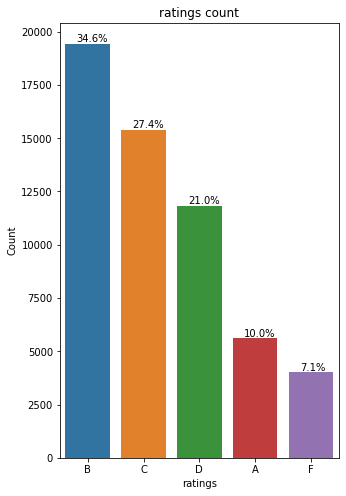

In [28]:
print_info(cleaned_data,'ratings')
create_bar_plot(cleaned_data,'ratings')

The data is follow exponential distribution. As most reviews rates are tend to be on the middle towards lower side, there are about 17.2% of reviews are on the extreme level. To be specificly, B is the most common(33.6%) rate given,and the second most common rate is cC, which contributes 27.6% of the all the ratings.

####  3.2 Top reviewed Movies

In [29]:
print_info(cleaned_data,'rotten_tomatoes_link')

Description:
count         56242
unique         1770
top       m/us_2019
freq            350
Name: rotten_tomatoes_link, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                          Count  Frequency (%)
m/us_2019                   350       0.622311
m/the_invisible_man_2020    276       0.490736
m/it_chapter_two            266       0.472956
m/halloween_2018            263       0.467622
m/a_quiet_place_2018        261       0.464066
...                         ...            ...
m/prey_2018                   1       0.001778
m/portals                     1       0.001778
m/dead_hooker_in_a_trunk      1       0.001778
m/forbidden_world             1       0.001778
m/bride_of_the_gorilla        1       0.001778

[1770 rows x 2 columns]


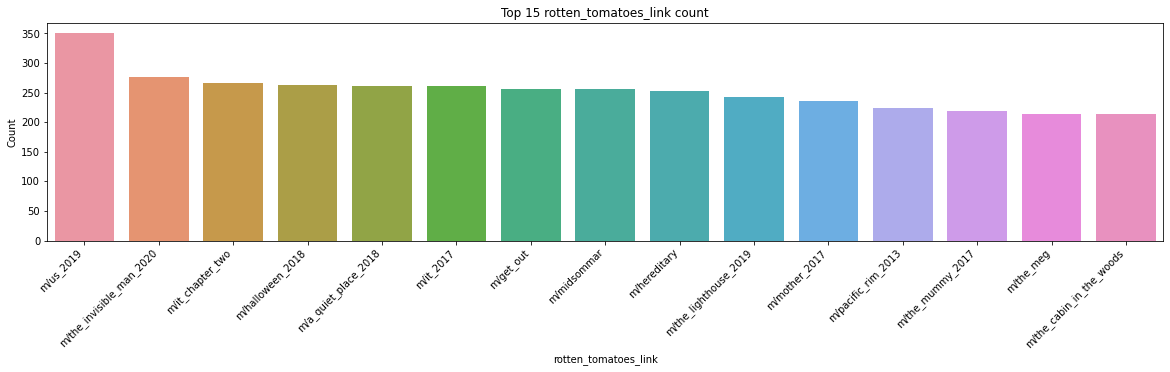

In [30]:
top_n_bar_plot(cleaned_data,'rotten_tomatoes_link',15)

The most reviwed movie is 'US' in 2019 followed by 'the_invisible_man' 2020.

####  3.3 Top publishers

Description:
count               56242
unique               1232
top       eFilmCritic.com
freq                 1036
Name: publisher_name, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                                 Count  Frequency (%)
eFilmCritic.com                   1036       1.842040
Reel Film Reviews                  669       1.189503
Slant Magazine                     634       1.127271
Mountain Xpress (Asheville, NC)    576       1.024146
Dennis Schwartz Movie Reviews      556       0.988585
...                                ...            ...
NY Rock                              1       0.001778
KyleSmithOnline.com                  1       0.001778
Rescu (Australia)                    1       0.001778
CLTure                               1       0.001778
The Twisted Girl Next Door           1       0.001778

[1232 rows x 2 columns]


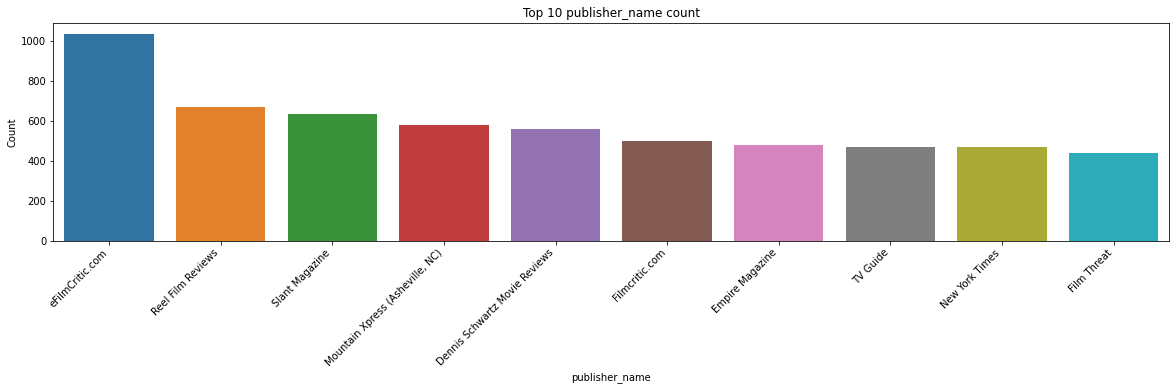

In [31]:
print_info(cleaned_data,'publisher_name')
top_n_bar_plot(cleaned_data,'publisher_name',10)

#### 3.4 Distribution of review date 

In [32]:
value_cnt_norm_cal(cleaned_data,'review_date').sort_index()

,Count,Frequency (%)
1800-01-01,3,0.005334
1960-05-22,1,0.001778
1963-03-28,1,0.001778
1981-08-21,1,0.001778
1981-10-15,2,0.003556
...,...,...
2020-10-21,11,0.019558
2020-10-23,2,0.003556
2020-10-26,4,0.007112
2020-10-27,1,0.001778


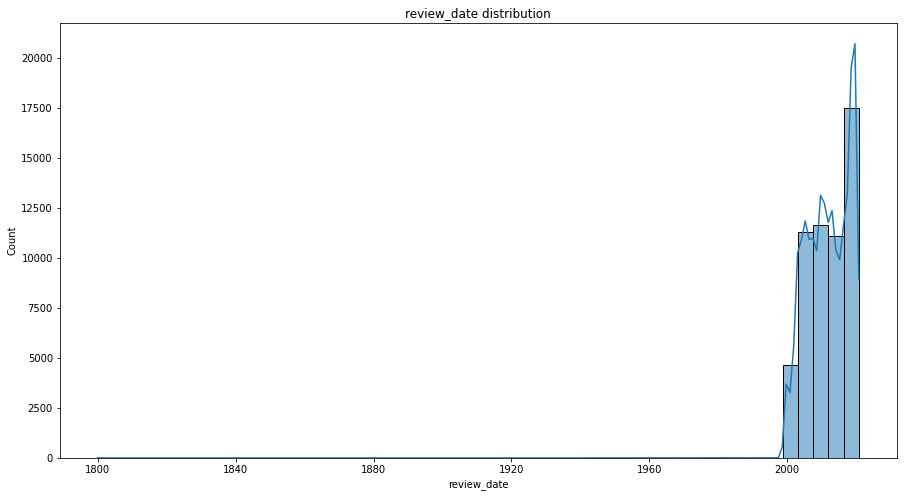

In [33]:
create_hist_plot(cleaned_data,'review_date',50)

It's kinda impossible that the review date starts from 1800. This outliers are caused most likly by data collection mistake. 

Let's only focuse on dates that after 2000. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Description:
count                   56216
unique                   6462
top       2000-01-01 00:00:00
freq                     1515
first     2000-01-01 00:00:00
last      2020-10-28 00:00:00
Name: review_date, dtype: object
**************************************************
Object type:
datetime64[ns]
**************************************************
Value count:
            Count  Frequency (%)
2000-01-01   1515       2.694962
2018-10-31    119       0.211684
2018-11-02    117       0.208126
2012-02-02    114       0.202789
2017-06-08     82       0.145866
...           ...            ...
2002-01-08      1       0.001779
2009-02-22      1       0.001779
2001-08-01      1       0.001779
2005-03-25      1       0.001779
2014-01-27      1       0.001779

[6462 rows x 2 columns]


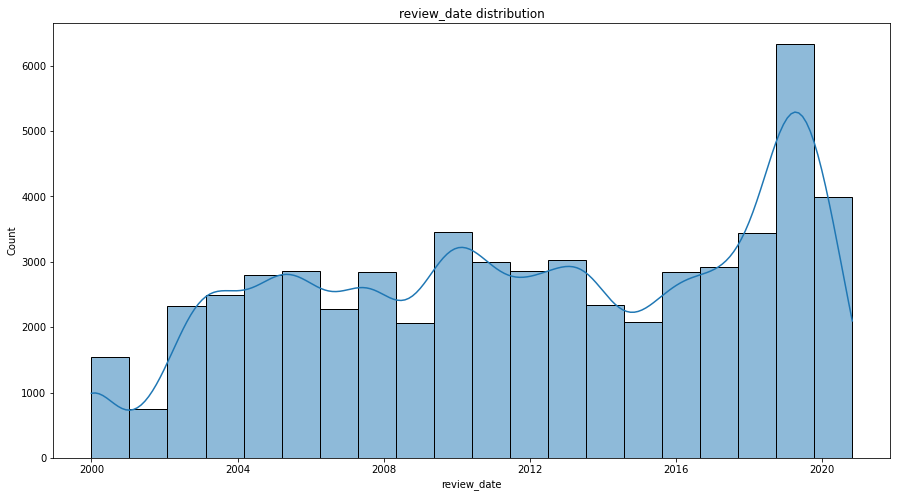

In [34]:
#cleaned_data[cleaned_data['review_date']>='2000-01-01'].review_date

print_info(cleaned_data[cleaned_data['review_date']>='2000-01-01'],'review_date')
create_hist_plot( cleaned_data[cleaned_data['review_date']>='2000-01-01'],'review_date',20)

#### 3.5 Review Content Length Distribution


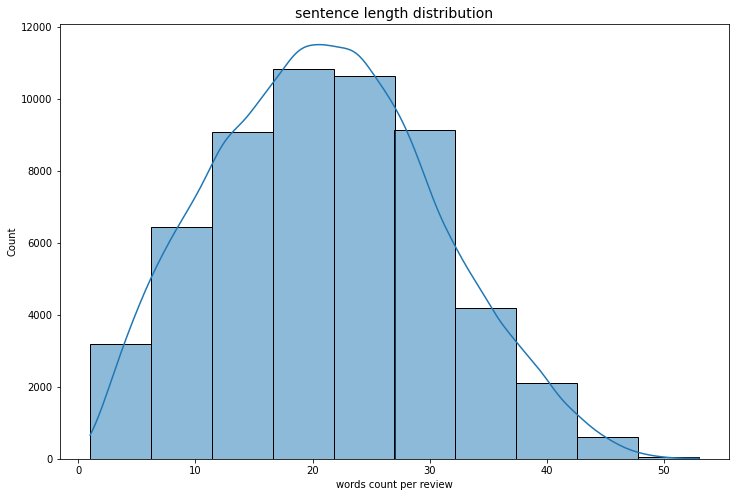

Longest sentence:  53  words.
Shortest sentence:  1  words.


In [35]:
length_dist = [len(x.split(" ")) for x in cleaned_data['review_content']]

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(length_dist,bins=10,kde=True)
plt.xlabel('words count per review')
plt.ylabel('Count')
plt.title('sentence length distribution', fontsize=14)
plt.show()

print('Longest sentence: ', max(length_dist)," words.")
print('Shortest sentence: ', min(length_dist)," words.")

## 4. Review Data Exploration

In [38]:
reviews_data = cleaned_data.copy()

### 4.1 No token

In [36]:
# convert text to lower-case, remove [], removes number and punctuation

def text_clean_1(text):
  text = text.lower()
  text = re.sub('\[.*?\]','',text)
  text = re.sub('\w*\d\w*','',text)
  text = re.sub('\n','',text)
  text = re.sub('[''""...]','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
  return text

cleaned_1 = lambda x : text_clean_1(x)

In [39]:
# apply first layer of cleaning 
reviews_data['cleaned1']=pd.DataFrame(reviews_data['review_content'].apply(cleaned_1))
reviews_data['cleaned1']

0         while dark water isnt a complete wash no pun i...
2         the picture is melancholy remembrance and its ...
3         a horror movie that sits there and drags and s...
4         just beneath its surface horror this film conc...
6         with extremely heavy echoes of his own  film r...
                                ...                        
107815    snappily taking potshots at its reason for exi...
107816    here i throw my hands up and cry pardon i was ...
107817    has the potential to become a minor hit on the...
107819    certainly not on the scale of a romero but at ...
107821    kevin hamedanis muddy heavyhanded parody of wa...
Name: cleaned1, Length: 56242, dtype: object

#### **Distribution**

In [40]:
def top_n_common_words(df,feature,n):
  reviews = [i.split(' ') for i in df[feature]] # split sentence into words 
  reviews = list(chain(*reviews)) # chain all words together 
  print('Total unique words: ', len(np.unique(np.array(reviews))))
  common_words_df = pd.DataFrame(Counter(reviews).most_common(n),columns=['words', 'count'])
  return common_words_df

In [41]:
top_20 = top_n_common_words(reviews_data,'cleaned1',20)
top_20.columns

Total unique words:  46219


Index(['words', 'count'], dtype='object')

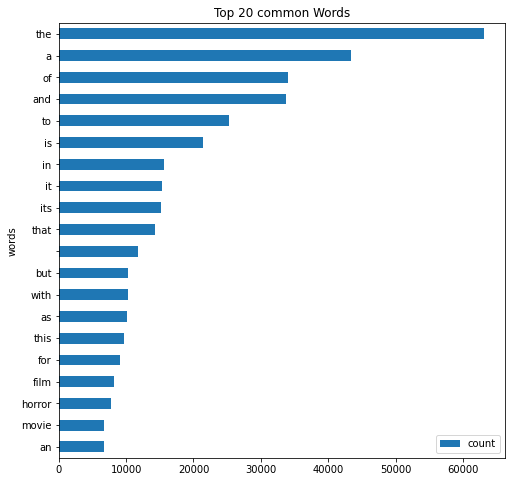

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

top_20.sort_values(by='count').plot.barh(x='words',y='count',ax=ax)
ax.set_title("Top {} common Words".format(20))
plt.show()

In [43]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

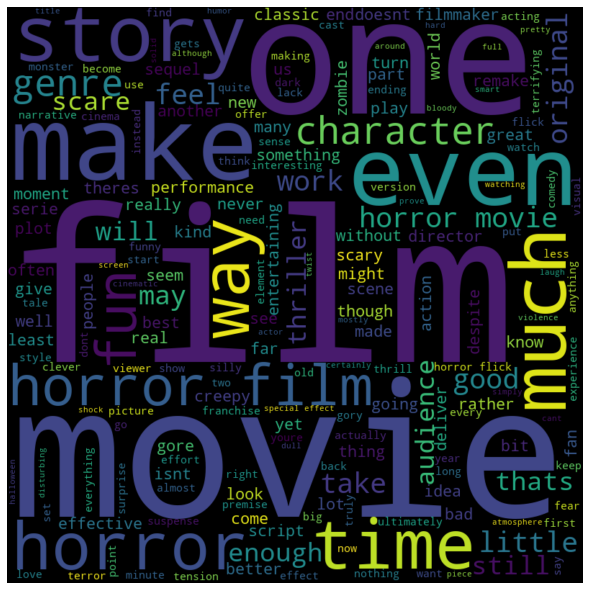

In [44]:
wordCloud_generator(reviews_data['cleaned1'])

Not much of insight from here

### 4.2 **NLTK**

In [74]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### 4.2.1 NLTK - all words

In [67]:
# adding words to NLTL stopwords list 

stopwords = stopwords.words('english')
newStopWords = ['film','movies','yet']
stopwords.extend(newStopWords)

In [70]:
def nltk_stopwords(data):
    words = []
    for i in data:
      if i.isalnum() and i not in stopwords:
          words.append(i)
    return words

def nltk(df, feature):
  # tokenize sentences to words
  df['words_nltk'] = df[feature].apply(word_tokenize)
  # remove stop works 
  df['words_nltk']= df['words_nltk'].apply(nltk_stopwords)
  print("Successfully created 'words_nltk' column")
  
def common_words_ratings(df,rating_col,words_col, n):
  common_words_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    words_list = []
    for w in df[df[rating_col] == i][words_col]:
      words_list.extend(w)
    common_words_ratings[i] = Counter(words_list).most_common(n)
  return common_words_ratings

In [71]:
nltk(reviews_data,'cleaned1')
common_words_ratings(reviews_data, 'ratings', 'words_nltk',20)

Successfully created 'words_nltk' column


,A,B,C,D,F
0,"(horror, 1138)","(horror, 3095)","(horror, 1858)","(movie, 1495)","(movie, 566)"
1,"(one, 836)","(movie, 2213)","(movie, 1748)","(horror, 1249)","(horror, 428)"
2,"(movie, 687)","(one, 1629)","(like, 1092)","(one, 922)","(one, 376)"
3,"(best, 407)","(like, 1152)","(one, 1043)","(like, 831)","(like, 270)"
4,"(films, 398)","(good, 1009)","(much, 834)","(much, 580)","(even, 260)"
5,"(like, 316)","(fun, 981)","(good, 747)","(even, 549)","(bad, 254)"
6,"(genre, 256)","(genre, 909)","(story, 674)","(story, 456)","(worst, 179)"
7,"(time, 234)","(story, 824)","(enough, 669)","(good, 448)","(would, 152)"
8,"(great, 232)","(films, 798)","(doesnt, 616)","(bad, 426)","(films, 137)"
9,"(classic, 226)","(even, 746)","(even, 611)","(make, 402)","(time, 134)"


#### 4.2.2 NLTK(pos_tag) - adjectives 

In [72]:
def get_adjective(x):
    adj = ['JJ', 'JJR', 'JJS']
    word = []
    for i in x:
        if i[1] in adj:
            word.append(i[0])
    return word

def nltk_postag_adj(df, feature):
  # add pos tags 
  df['pos_tag'] = df[feature].apply(nltk.pos_tag)
  # get adjectives
  df['adj_words'] = df['pos_tag'].apply(get_adjective)
  print("Successfully created 'adj_words' column")

def common_adj_ratings(df,rating_col,adj_col, n):
  common_adj_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    adj_list = []
    for w in df[df[rating_col] == i][adj_col]:
      adj_list.extend(w)
    common_adj_ratings[i] = Counter(adj_list).most_common(n)
  return common_adj_ratings

In [ ]:
nltk_postag_adj(reviews_data,'words_nltk')
common_adj_ratings(reviews_data, 'ratings', 'adj_words',20)

#### 4.2.3 NLTK(pos_tag) - nouns 

In [58]:
def get_nouns(x):
    noun = ['NN', 'NNS', 'NNP', 'NNPS']
    word = []
    for i in x:
      if i[1] in noun:
        word.append(i[0])
    return word

def nltk_postag_noun(df, feature):
  # get noun
  df['noun_words'] = df['pos_tag'].apply(get_nouns)
  print("Successfully created 'noun_words' column")

def common_noun_ratings(df,rating_col,noun_col, n):
  common_noun_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    noun_list = []
    for w in df[df[rating_col] == i][noun_col]:
      noun_list.extend(w)
    common_noun_ratings[i] = Counter(noun_list).most_common(n)
  return common_noun_ratings

In [59]:
nltk_postag_noun(reviews_data,'words_nltk')

Successfully created 'noun_words' column


In [60]:
common_noun_ratings(reviews_data, 'ratings', 'noun_words',20)

,A,B,C,D,F
0,"(horror, 1044)","(film, 2965)","(film, 2152)","(film, 1557)","(movie, 566)"
1,"(film, 1032)","(horror, 2814)","(movie, 1748)","(movie, 1495)","(film, 515)"
2,"(movie, 687)","(movie, 2213)","(horror, 1712)","(horror, 1139)","(horror, 381)"
3,"(films, 388)","(story, 824)","(story, 674)","(story, 456)","(movies, 157)"
4,"(movies, 252)","(films, 758)","(films, 518)","(time, 376)","(time, 134)"
5,"(time, 234)","(fun, 718)","(time, 493)","(movies, 372)","(films, 132)"
6,"(story, 211)","(time, 654)","(fun, 461)","(films, 362)","(nothing, 116)"
7,"(genre, 195)","(movies, 636)","(way, 452)","(characters, 329)","(way, 99)"
8,"(way, 156)","(way, 628)","(theres, 422)","(nothing, 302)","(story, 98)"
9,"(years, 153)","(genre, 615)","(movies, 410)","(way, 297)","(thing, 97)"


#### 4.2.4 NLTK  (bi-grams)

In [65]:
def common_bigram_ratings(df,rating_col,word_col, n):
  common_bigrams_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    word_list = []
    for w in df[df[rating_col] == i][word_col]:
      word_list.extend(w)
    bigram_list = list(nltk.bigrams(word_list))
    common_bigrams_ratings[i] = Counter(bigram_list).most_common(n)
  return common_bigrams_ratings

In [66]:
common_bigram_ratings(reviews_data, 'ratings', 'words_nltk',20)

,A,B,C,D,F
0,"((horror, film), 190)","((horror, film), 381)","((horror, film), 224)","((horror, movie), 202)","((horror, movie), 71)"
1,"((one, best), 135)","((horror, movie), 348)","((horror, movie), 207)","((horror, film), 158)","((horror, film), 63)"
2,"((horror, movie), 118)","((horror, films), 162)","((feels, like), 151)","((feels, like), 112)","((one, worst), 38)"
3,"((horror, films), 91)","((horror, movies), 148)","((special, effects), 114)","((special, effects), 90)","((worst, movie), 28)"
4,"((horror, movies), 71)","((feels, like), 128)","((horror, flick), 104)","((horror, flick), 74)","((ever, made), 26)"
5,"((ever, made), 65)","((horror, fans), 123)","((horror, films), 69)","((yet, another), 57)","((worst, films), 25)"
6,"((best, horror), 63)","((horror, flick), 122)","((horror, fans), 66)","((jump, scares), 52)","((waste, time), 23)"
7,"((pans, labyrinth), 44)","((special, effects), 116)","((jump, scares), 63)","((horror, movies), 51)","((horror, flick), 23)"
8,"((horror, genre), 43)","((one, best), 114)","((horror, movies), 62)","((horror, films), 46)","((look, like), 22)"
9,"((ive, seen), 41)","((horror, genre), 105)","((blair, witch), 58)","((first, film), 44)","((special, effects), 21)"


## Model Training and Evaluations

In [427]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [419]:
#train and split

X = reviews_data['cleaned1']
Y = reviews_data['ratings']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, random_state =225)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )

x_train : 49020
x_test : 12256
y_train : 49020
y_test : 12256


#### Base model

In [423]:
tifd_vec = TfidfVectorizer()
dt_model = DecisionTreeClassifier()

# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',dt_model) ])
model.fit(x_train, y_train)

Pipeline(steps=[('Vectorize', TfidfVectorizer()),
                ('Classifier', DecisionTreeClassifier())])

In [432]:
def evaluation(preds, test_y):
  sns.heatmap(confusion_matrix(preds,test_y),annot=True,fmt='d')
  print('Accuracy: ',accuracy_score (preds,test_y))
  print(classification_report(preds, test_y))

Accuracy:  0.3136422976501306
              precision    recall  f1-score   support

           A       0.14      0.18      0.15       903
           B       0.42      0.40      0.41      4295
           C       0.38      0.31      0.34      4171
           D       0.23      0.26      0.25      2311
           F       0.08      0.14      0.10       576

    accuracy                           0.31     12256
   macro avg       0.25      0.26      0.25     12256
weighted avg       0.33      0.31      0.32     12256



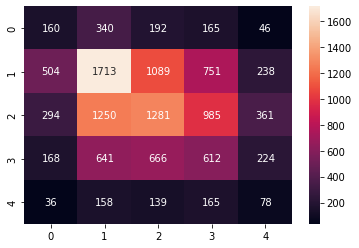

In [433]:
predictions = model.predict(x_test)
evaluation(predictions, y_test)

### NLTK